In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [2]:
data, labels = datasets.make_regression(n_samples=1500, n_features = 2, n_informative = 2, random_state=12)

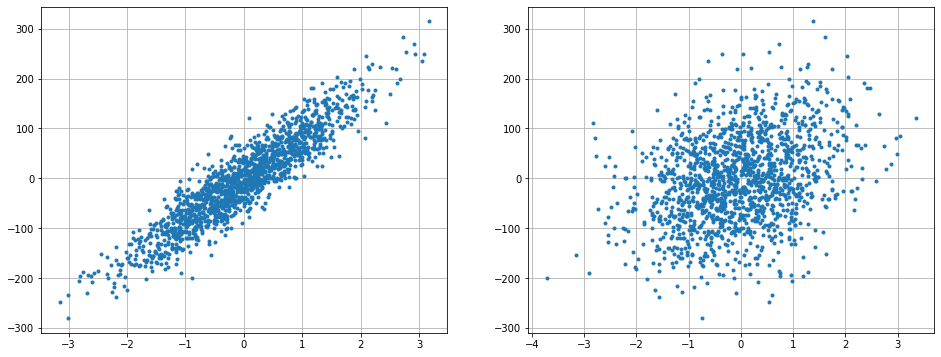

In [3]:
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
plt.plot(data[:,0],labels, '.')
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(data[:,1],labels, '.')
plt.grid(True)

plt.show()

In [4]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index 
        self.t = t  
        self.true_branch = true_branch  
        self.false_branch = false_branch  

In [5]:
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data 
        self.labels = labels  
        self.prediction = self.predict() 
        
    def predict(self):
        classes = {}
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1  
        prediction = max(classes, key=classes.get)
        return prediction

In [6]:
def disp(data: list):
    tmp = 0
    for d in data:
        tmp += (d-np.mean(data))**2
    return tmp / len(data)

In [7]:
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [8]:
def quality(left_data, right_data, current_disp):
    p = float(left_data.shape[0]) / (left_data.shape[0] + right_data.shape[0]) # для правого (1-p)
    return current_disp - p * disp(left_data) - (1 - p) * disp(right_data) # Функционал качества

In [9]:
def find_best_split(data, labels):
    min_leaf = 5
    current_disp = disp(labels) 
    best_quality = 0
    best_t = None 
    best_index = None 
    n_features = data.shape[1]
    
    for index in range(n_features): 
        t_values = [row[index] for row in data]
        
        for t in t_values: 
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t) 
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue 
            
            current_quality = quality(true_labels, false_labels, current_disp)
            
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [10]:
def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels) 

    if (quality == 0):
        return Leaf(data, labels) 
    
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)
    return Node(index, t, true_branch, false_branch)

In [11]:
from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(data, 
                                                                                     labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [12]:
my_tree = build_tree(train_data, train_labels)
print(my_tree)
display(my_tree.index, my_tree.t, my_tree.true_branch , my_tree.false_branch)

0

0.09191018320062376

In [13]:
def print_tree(node, spacing=""):

    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))
    
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0
Порог 0.09191018320062376
--> True:
  Индекс 0
  Порог -0.8122239841081902
  --> True:
    Индекс 0
    Порог -1.4163220322580903
    --> True:
      Индекс 0
      Порог -2.0273535745122775
      --> True:
        Индекс 1
        Порог -0.6474307801655981
        --> True:
          Прогноз: -209.38843002156764
        --> False:
          Индекс 0
          Порог -2.55857133955266
          --> True:
            Прогноз: -196.44482193180588
          --> False:
            Индекс 1
            Порог 0.5287250661290652
            --> True:
              Прогноз: -183.55612827537792
            --> False:
              Прогноз: -164.38083021499264
      --> False:
        Индекс 1
        Порог 0.3762671581281835
        --> True:
          Индекс 1
          Порог -0.7208719427762792
          --> True:
            Индекс 1
            Порог -1.2335897301798158
            --> True:
              Прогноз: -172.33319309570064
            --> False:
              Прогноз: -16

In [14]:
def reg_object(obj, node):

    if isinstance(node, Leaf): 
        answer = node.prediction 
        return answer

    if obj[node.index] <= node.t: 
        return reg_object(obj, node.true_branch) 
    else:
        return reg_object(obj, node.false_branch) 

In [15]:
def predict(data, tree):
    
    reg = []
    for obj in data:
        prediction = reg_object(obj, tree)
        reg.append(prediction)
    return reg

In [16]:
y_p = predict(data, my_tree)

In [17]:
y_p[:10]

[-110.93727708017214,
 -56.55957088317378,
 -17.672532760285844,
 -100.3403225736075,
 146.9761146024489,
 62.330542576182836,
 -65.0111161638469,
 -209.38843002156764,
 -96.46046985790726,
 0.12355124861700179]

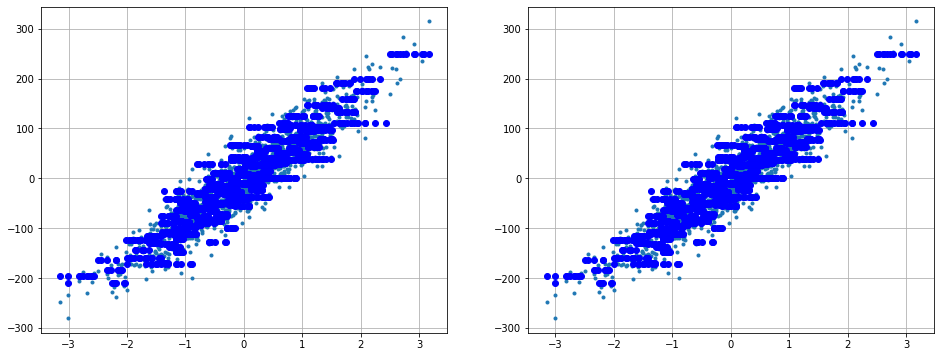

In [18]:
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
plt.plot(data[:,0],labels, '.')
plt.plot(data[:,0],y_p, 'ob')
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(data[:,0],labels, '.')
plt.plot(data[:,0],y_p, 'ob')
plt.grid(True)

plt.show()